In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 线性回归

初始化生成两个变量,并且画出图形

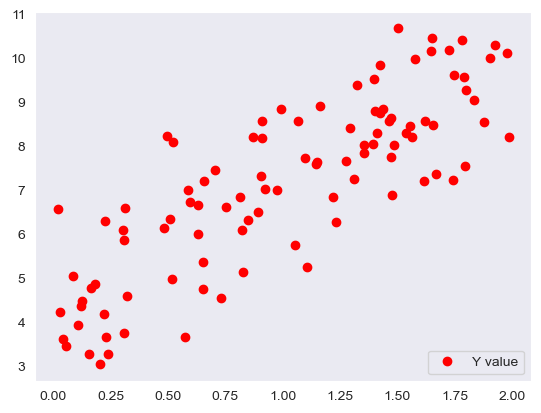

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
plt.plot(X, y, 'ro', label='Y value')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [3]:
#转换成 1-D array
X_b = np.c_[
        np.ones((100, 1)), X
]
# add x0 = 1 to each instance
theta_best = np.linalg.inv(
                X_b.T.dot(X_b)).dot(X_b.T).dot(y)
## 根据公式的出计算结果
theta_best

array([[4.31289097],
       [2.8036588 ]])

我们本来希望$θ_0=4，θ_1=3$，而不是$θ_0=4.215，θ_1=2.770$ 。足够接近了，但因为有一些噪声使我们无法恢复原始函数的确切参数。
tip： 这里我们可以直接使用公式来计算，但是数据量比较大的时候矩阵并不是那么容易计算的

## 模型应用

In [4]:
# Now you can make predictions using θ:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.31289097],
       [9.92020857]])

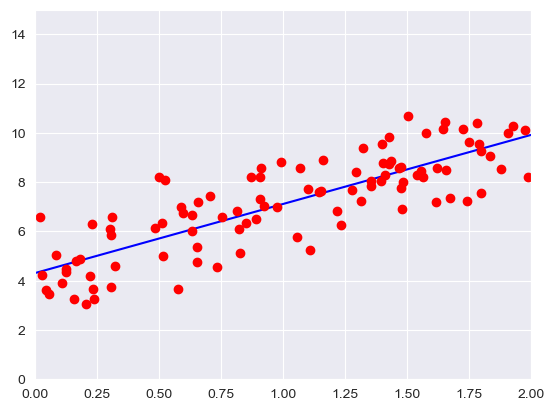

In [5]:
plt.plot(X_new, y_predict,"b-")
plt.plot(X, y, 'ro', label='Y value')
plt.axis([0, 2, 0, 15])
plt.show()
# plt.savefig(f, format="svg")

## 线性回归pytorch

梯度下降方式(sgd)的方式来得到最终的结果。

In [43]:
from torch import nn
import torch
import random

In [44]:
def synthetic_data(w, b, num_examples):  # @save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


In [45]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 这些样本是随机读取的，没有特定的顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]
        )
        yield features[batch_indices], labels[batch_indices]

In [46]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [47]:
def squared_loss(y_hat, y ):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


In [48]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [50]:
batch_size = 10
for X, y  in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.9518, -0.8391],
        [-0.2330, -0.2599],
        [ 0.5765, -0.2029],
        [ 1.1985,  0.5299],
        [ 1.9500,  0.8552],
        [ 1.4198, -0.2481],
        [ 0.2654, -3.0374],
        [-0.2849,  0.9984],
        [ 0.0349, -0.5467],
        [ 0.8624, -0.7562]]) 
 tensor([[ 8.9363],
        [ 4.5952],
        [ 6.0411],
        [ 4.7953],
        [ 5.1907],
        [ 7.8735],
        [15.0694],
        [ 0.2567],
        [ 6.1068],
        [ 8.5004]])


In [65]:
def synthetic_data(w, b, num_examples):
    """
    Generate y = Xw + b + noise.
    Defined in :numref:`sec_linear_scratch`
    torch.normal()  # 该函数返回从单独的正态分布中提取的随机数的张量，该正态分布的均值是mean，标准差是std
    torch.reshape() 用来改变tensor的shape。
    """
    X = torch.normal(0, 1, (num_examples, len(w)))  #正态分布的 X
    y = torch.matmul(X, w) + b # matmul 向量乘法
    y += torch.normal(mean=0, std=0.01, size=y.shape) # y 加上正态分布的噪音
    return X, torch.reshape(y, (-1, 1))

在我们开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

In [60]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [61]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # y^i和y的小批量损失
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.029956
epoch 2, loss 0.000106
epoch 3, loss 0.000051


In [62]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0006, -0.0005], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)


[torch.nn.Linear](https://pytorch.org/docs/1.12/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)
我们将两个参数传递到nn.Linear中。 第一个指定输入特征形状，就是2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1。

In [31]:
liner_net = nn.Linear(2,1)
# X_tensor = torch.tensor(X)
#output = lin_reg(X_tensor)
# lin_reg.intercept_, lin_reg.coef_
# 预测

BGD - Batch GD computing the gradients based on the full training set
SGD - Stochastic GD based on just one instance
MBGD- batch GD computes the gradients(梯度) on small random sets of instances called mini- batches.

上面的显示如果，在数据集比较小的时候，